In [1]:
%env CUDA_VISIBLE_DEVICES=7
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=7
env: OMP_NUM_THREADS=16


In [3]:
# !git clone https://github.com/Vahe1994/AQLM.git && cd AQLM && git checkout 559a36681398d7189297fccf3b1e59e8e030e942

In [4]:
import os
import sys
sys.path.insert(0, 'AQLM')

import time
import random
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

from src.aq import QuantizedWeight

torch.set_num_threads(16)
torch.backends.cudnn.allow_tf32 = False
torch.backends.cuda.matmul.allow_tf32 = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# num_codebooks = 2
# nbits_per_codebook = 8
out_group_size = 1
in_group_size = 8
batch_size = 16384
beam_size = 1
sparsity_regularizer = 0
print_frequency = 10
scale_nbits = 0    # 0 means no scales, 16 means no compression;
codebook_values_nbits = 16  # less than 16 means we quantize codebooks as well
init_max_iter = 100
steps_per_epoch = 100

relative_mse_tolerance = 0.01

In [27]:
def get_loss_after_quantization(reference_weight, XTX, num_codebooks, nbits_per_codebook, relative_mse_tolerance = 0.01, verbose=False):
    def get_loss():
        delta_weight = (quantized_weight() - reference_weight).double()
        return (delta_weight @ XTX.double()).flatten() @ delta_weight.flatten()
    
    quantized_weight = QuantizedWeight(
        XTX=XTX, reference_weight=reference_weight, num_codebooks=num_codebooks,
        nbits_per_codebook=nbits_per_codebook, scale_nbits=scale_nbits, 
        out_group_size=out_group_size, in_group_size=in_group_size,
        verbose=verbose, max_iter=init_max_iter,   # faster init, not tested
    )
    if verbose:
        print("AVG bits:", quantized_weight.estimate_nbits_per_parameter())
    opt = torch.optim.Adam(quantized_weight.parameters(), lr=1e-4, betas=(0.0, 0.95), amsgrad=True)

    previous_best_loss = float('inf')
    best_loss = float('inf')
    
    for epoch in range(1_000_000_000):
        done = False
        
        for step in range(steps_per_epoch):
            loss = get_loss()
        
            if not torch.isfinite(loss).item():
                raise ValueError(f"Quantization loss is {loss}")
    
            best_loss = min(loss.item(), best_loss)
    
            if step == 0:
                if loss.item() / previous_best_loss > (1.0 - relative_mse_tolerance):
                    if verbose:
                        print(f'{previous_best_loss = }')
                        print(f'{loss.item() = }')
                    return quantized_weight.estimate_nbits_per_parameter(), get_loss().item()
                    
                    done = True
                    break # early stopping; no updates after last epoch's beam search
                previous_best_loss = min(previous_best_loss, loss.item())
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if verbose and ((epoch * steps_per_epoch + step) % print_frequency == 0):
                print(f"epoch={epoch}\tstep={step}\tloss={loss.item():.10f}\t")
    
        if done:
            break
        
        quantized_weight.beam_search_update_codes_(
            XTX, reference_weight, beam_size=beam_size,
            sparsity_regularizer=sparsity_regularizer, dim_rng=random.Random(),
            verbose=verbose,
        )

    return quantized_weight.estimate_nbits_per_parameter(), get_loss().item()

In [33]:
x_test = torch.randn(1024, 1024).cuda()
XTX = torch.eye(1024).cuda()

In [45]:
import itertools

configs = []

for n_codebooks, n_bits_per_codebook in itertools.product(range(1, 5), range(1, 17)):
    print(n_codebooks, n_bits_per_codebook)
    bits, loss = get_loss_after_quantization(x_test, XTX, n_codebooks, n_bits_per_codebook)
    loss = (loss / (x_test.norm() ** 2)).item()
    configs.append({
        'n_codebooks': n_codebooks,
        'n_bits_per_codebook': n_bits_per_codebook,
        'wbits': bits,
        'mse': loss,
    })

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16


In [53]:
import pandas as pd

configs_df = pd.DataFrame(configs)

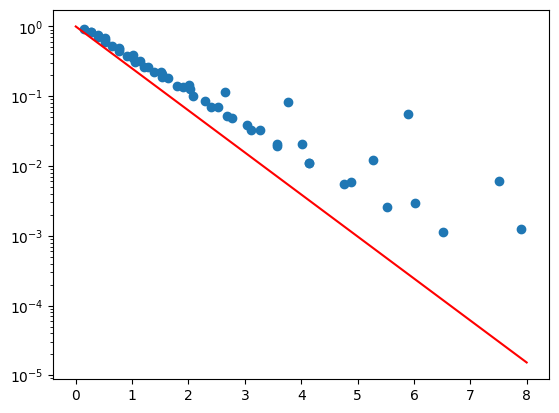

In [61]:
import numpy as np
import matplotlib.pyplot as plt

to_plot = configs_df[configs_df['wbits'] < 8.0]

grid = np.linspace(0, 8)

plt.plot(grid, 4 ** -grid, color='red')
plt.scatter(to_plot['wbits'], to_plot['mse'])

plt.yscale('log')

In [64]:
print(configs_df.to_csv())

,n_codebooks,n_bits_per_codebook,wbits,mse
0,1,1,0.140869140625,0.919545590877533
1,1,2,0.26611328125,0.8224712610244751
2,1,3,0.3916015625,0.7082441449165344
3,1,4,0.517578125,0.6006791591644287
4,1,5,0.64453125,0.5165958404541016
5,1,6,0.7734375,0.43828025460243225
6,1,7,0.90625,0.3716720640659332
7,1,8,1.046875,0.3143085539340973
8,1,9,1.203125,0.2638692259788513
9,1,10,1.390625,0.22001385688781738
10,1,11,1.640625,0.18064697086811066
11,1,12,2.015625,0.1454421728849411
12,1,13,2.640625,0.1135108694434166
13,1,14,3.765625,0.0839976817369461
14,1,15,5.890625,0.056254711002111435
15,1,16,10.015625,0.028201874345541
16,2,1,0.26611328125,0.8393333554267883
17,2,2,0.5166015625,0.644393801689148
18,2,3,0.767578125,0.4761597216129303
19,2,4,1.01953125,0.35457074642181396
20,2,5,1.2734375,0.2630593776702881
21,2,6,1.53125,0.1916685402393341
22,2,7,1.796875,0.13853929936885834
23,2,8,2.078125,0.09932401776313782
24,2,9,2.390625,0.07067837566137314
25,2,10,2.765625,0.04867278411984444
26,2,11